In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import pickle


import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3,4,5,6,7,8])

os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf
from ONE_YR.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf
from helpers import eval_function_new


In [2]:
PF_SIZE = 500


base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = PF_SIZE  # DONT CHANGE HERE!!
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")


fixed_shrk_name = 'cov1Para'
opt_shrk_name = 'cov1Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\{opt_shrk_name}_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_rawres_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    rawres_fixed_shrk_data = pickle.load(f)

# IMPORT FACTORS DATA AND PREPARE FOR FURTHER USE
factor_path = fr"{base_folder_path}\helpers"
factors = pd.read_csv(factor_path + "/all_factors.csv")
factors = factors.pivot(index="date", columns="name", values="ret")

# as our shrk data starts from 1980-01-15 our factors data should too
start_date = str(optimal_shrk_data['date'].iloc[0])
start_date = start_date[0:4] + '-' + start_date[4:6] + "-" + start_date[6:]
start_idx = np.where(factors.index == start_date)[0][0]
factors = factors.iloc[start_idx:start_idx+fixed_shrk_data.shape[0], :]

cov1para_shrk = optimal_shrk_data['shrk_factor'].values[5040:]

len_train = 5040
end_date = fixed_shrk_data.shape[0]
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]

In [3]:
all_res = fixed_shrk_data.iloc[:, 2:].copy() * 100
all_factors = all_res.columns.astype(float).values
Y = all_res.idxmin(axis=1).values.astype(float)
opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, all_res.idxmin(axis=1).values])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values


ROLL_WINDOW = 1
ROLL_WINDOW_INPUTS = 252
rolling_opt = pd.Series(opt_values).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values

Y = pd.Series(Y).rolling(window=1, min_periods=1).mean().astype(np.int64).values
opt_values = pd.Series(opt_values).rolling(window=1, min_periods=1).mean().astype(np.int64).values



In [4]:
opt_values

array([15, 15, 15, ..., 41, 51, 33], dtype=int64)

In [5]:
opt_v3

array([7.0, 7.0, 7.0, ..., 5.756721026489685, 6.236064874905287,
       8.599690497506828], dtype=object)

In [6]:
params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, rolling_opt, rolling_opt2, optimal_shrk_data['shrk_factor'].values.astype(np.float64)*100]  
}

X = re_hf.load_additional_train_data(**params)

var_names = [
    "Lagged Optimal Action",
    "Momentum",
    "Trace",
    "Average Correlation",
    "EMWA",
    "Universe Volatility",
    "Average Volatility",
    "SD corresp. to Lagged Optimal Action",
    "Rolling Optimal Action",
    "Rolling Optimal SD",
    "Lineaer Shrinkage"
    ]

In [7]:
X[5040:].shape

(5313, 11)

In [11]:
tmp = np.corrcoef(X[5040:].astype(float).T)

#px.imshow(tmp)

In [12]:
tmp.shape

(11, 11)

In [16]:
tmp = pd.DataFrame(tmp)
tmp.index = var_names
tmp.columns = var_names

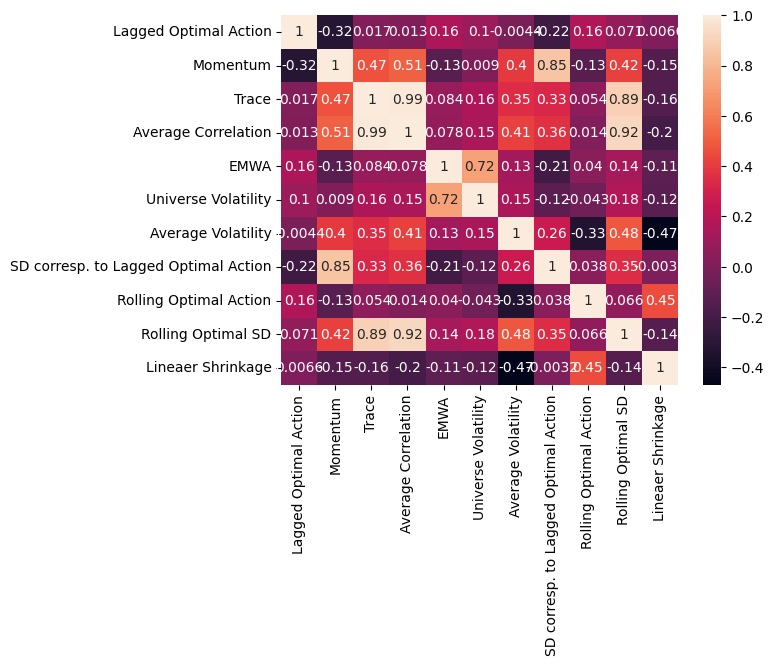

In [17]:
import seaborn as sns
sns.heatmap(tmp, annot=True)
plt.show()

### Variable Importance

In [12]:
from sklearn.ensemble import RandomForestRegressor
def general_single_output_RF_Lagged(X, Y, len_train, single_train=True, expanding=False, train_size=None,
                                    model_params={
                                        'max_features': 1.0
                                    } ):

    model_fits = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            return model_fits
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = RandomForestRegressor(random_state=123, **model_params)
                regr = regr.fit(x_train, y_train)
                model_fits.append(regr)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    regr = RandomForestRegressor(random_state=123, **model_params)
                    regr = regr.fit(x_train, y_train)
                    # TMP
                    return [regr]
    return model_fits

model_fits = general_single_output_RF_Lagged(X=X, Y=Y, len_train=len_train, single_train=False)


In [7]:
def feat_imp_mdi(fit, feat_names=None):
    x = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    x = pd.DataFrame.from_dict(x, orient='index')
    if feat_names is not None:
        x.columns=feat_names

    x = x.replace(0, np.nan) # since max_features=1
    imp = pd.concat({'mean': x.mean(), 'std': x.std()*x.shape[0]**-0.5}, axis=1)
    imp /= imp['mean'].sum()
    return imp

In [17]:
lst=[]
lst = [feat_imp_mdi(x).loc[:, 'mean'] for x in model_fits]


In [ ]:
rebdates = optimal_shrk_data.iloc[5040:].date
rebdates = pd.to_datetime(rebdates, format="%Y%m%d")
tmp = range(0, rebdates.shape[0], 21)
rebdates = rebdates.iloc[tmp]

In [71]:
a = pd.concat(lst, axis=1)
a.index = var_names
a.columns = rebdates
varimp_means = a.mean(axis=1)
varimp_sds = a.std(axis=1)

In [72]:
px.line(a.T)

In [73]:
px.bar(a.T.mean())

In [70]:
rebdates = optimal_shrk_data.iloc[5040:].date
rebdates = pd.to_datetime(rebdates, format="%Y%m%d")
tmp = range(0, rebdates.shape[0], 21)
rebdates = rebdates.iloc[tmp]

In [77]:
a = a.T
a

,SD corresp. to Lagged Optimal Action,Lagged Optimal Action,Momentum,Trace,Average Correlation,EMWA,Universe Volatility,Average Volatility,Rolling Optimal Action,Rolling Optimal SD,Lineaer Shrinkage
date,,,,,,,,,,,
2000-12-18,0.057111,0.057414,0.060000,0.089732,0.040615,0.035418,0.118154,0.064357,0.151507,0.159082,0.166610
2001-01-19,0.055480,0.059049,0.063772,0.086710,0.039810,0.036092,0.116041,0.063496,0.153817,0.159464,0.166269
2001-02-20,0.054172,0.061393,0.067180,0.083029,0.041412,0.037603,0.113655,0.063968,0.151235,0.163227,0.163124
2001-03-21,0.055461,0.056854,0.061602,0.085575,0.040750,0.034979,0.118018,0.062793,0.157518,0.157432,0.169018
2001-04-20,0.056640,0.058877,0.062531,0.079795,0.040519,0.037034,0.116200,0.060934,0.157051,0.176587,0.153831
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,0.061921,0.072845,0.075133,0.079679,0.057834,0.059135,0.104960,0.076268,0.126814,0.174131,0.111281
2021-10-01,0.061421,0.072035,0.078163,0.080861,0.053231,0.057374,0.108599,0.076471,0.130098,0.172460,0.109288
2021-11-01,0.061540,0.069600,0.078158,0.079833,0.055441,0.057729,0.106907,0.080713,0.131518,0.170864,0.107696


In [79]:
pth = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\jfec_additional_results"
a.to_csv(pth+"//variable_imp_RL_L.csv")

### Save OOS Results of Best model

In [320]:
OUT_PATH = rf"H:\all\RL_Shrinkage_2024\ONE_YR\Linear_Shrinkage\results\p{PF_SIZE}"
oos_daily_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res])
pd.Series(oos_daily_rets).to_csv(f"{OUT_PATH}/OOS_daily_returns.csv")

In [321]:
pd.read_csv(OUT_PATH + "/OOS_daily_returns.csv", index_col=0).values.reshape(-1,)

array([ 0.0088263 ,  0.00684646, -0.01837157, ...,  0.00673835,
        0.01559732,  0.01073563])

### For Best Model, 
- create grid with AV and SD with convex combinations of the best OOS fixed intensity 
- create our model with the same mean as best OOS fixed intensity

In [322]:
convex_combo_sd = []
convex_combo_av = []
convex_combo_daily_rets = []

OPT_OOS_FIXED_SHRK_DICT = {
    30: 0.13, 
    50: 0.2, 
    100: 0.23, 
    225: 0.24, 
    500: 0.24
    }

OPT_OOS_FIXED_SHRK = OPT_OOS_FIXED_SHRK_DICT[PF_SIZE]
OUT_PATH = rf"H:\all\RL_Shrinkage_2024\ONE_YR\Linear_Shrinkage\results\p{PF_SIZE}"

for a in list(range(0,11,1)):
    a = a/10   
    x = (np.round((mapped_res * (1-a) + OPT_OOS_FIXED_SHRK * a), 2))
    daily_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, x])   
    convex_combo_daily_rets.append(daily_rets)                  
    convex_combo_av.append(daily_rets.mean() * 252 * 100)
    convex_combo_sd.append(daily_rets.std()* np.sqrt(252) * 100)

convex_combo_av = pd.DataFrame(convex_combo_av, index=[i/10 for i in range(0,11)], columns=[PF_SIZE]).T
convex_combo_sd = pd.DataFrame(convex_combo_sd, index=[i/10 for i in range(0,11)], columns=[PF_SIZE]).T
convex_combo_daily_rets = pd.DataFrame(convex_combo_daily_rets, index=[i/10 for i in range(0,11)]).T

In [323]:
x = np.round(mapped_res * (OPT_OOS_FIXED_SHRK/np.mean(mapped_res)), 2)
x = [x if x<1 else 1 for x in x]
daily_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, x])
convex_combo_av['re-scaled'] = daily_rets.mean() * 252 * 100
convex_combo_sd['re-scaled'] = daily_rets.std()* np.sqrt(252) * 100
convex_combo_daily_rets['re-scaled'] = daily_rets

convex_combo_av.to_csv(OUT_PATH + "/Convex_Combo_AV.csv")
convex_combo_sd.to_csv(OUT_PATH + "/Convex_Combo_SD.csv")
convex_combo_daily_rets.to_csv(OUT_PATH + "/Convex_Combo_DailyReturns.csv")

In [324]:
pd.read_csv(OUT_PATH + "/Convex_Combo_SD.csv", index_col=0)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,re-scaled
500,10.446073,10.426807,10.413615,10.401101,10.394968,10.391604,10.391336,10.395664,10.401599,10.414826,10.432742,10.410633


### save oralce and shrinkage intensities of model 

In [325]:
### get oracle
OOS_Rebdates_indexer = list(range(0, 5313, 21))
oracle_min_idx = all_res.iloc[5040:].iloc[OOS_Rebdates_indexer].idxmin(axis=1).astype(np.float64)
oracle_min_idx_repeated = np.repeat(oracle_min_idx, 21).values
oracle_daily_oos_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, ].loc[:, oracle_min_idx_repeated])

In [330]:
px.line(rawres_fixed_shrk_data.iloc[5040:, ].std() * np.sqrt(252)  *100)

In [326]:
pd.Series(mapped_res, dtype=np.float64).to_csv(OUT_PATH + f"/oos_linear_model_intensity_p{PF_SIZE}.csv")
pd.Series(oracle_min_idx_repeated).to_csv(OUT_PATH + f"/oos_linear_oracle_intensity_p{PF_SIZE}.csv")
pd.Series(oracle_daily_oos_rets).to_csv(OUT_PATH + f"/oos_linear_oracle_dailyrets_p{PF_SIZE}.csv")

## TEMPORARY

In [16]:
linear_model_intensity_p500 = pd.read_csv(r"H:\all\RL_Shrinkage_2024\ONE_YR\Linear_Shrinkage\results\p500\oos_linear_model_intensity_p500.csv", index_col=0)
linear_oracle_intensity_p500 = pd.read_csv(r"H:\all\RL_Shrinkage_2024\ONE_YR\Linear_Shrinkage\results\p500\oos_linear_oracle_intensity_p500.csv", index_col=0)

In [11]:
dates = permnos.index
dates = pd.to_datetime(dates, format="%Y%m%d")
dates[5040:]

DatetimeIndex(['2000-12-18', '2000-12-19', '2000-12-20', '2000-12-21',
               '2000-12-22', '2000-12-26', '2000-12-27', '2000-12-28',
               '2000-12-29', '2001-01-02',
               ...
               '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21',
               '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27',
               '2022-01-28', '2022-01-31'],
              dtype='datetime64[ns]', name='rebalancing_date', length=5313, freq=None)

In [17]:
linear_model_intensity_p500.index = dates[5040:]
linear_oracle_intensity_p500.index = dates[5040:]

In [22]:
p500_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\Linear_Shrinkage\results\p500"
linear_model_intensity_p500.to_csv(p500_path + "\\oos_linear_model_intensity_withdates_p500.csv")
linear_oracle_intensity_p500.to_csv(p500_path + "\\oos_linear_oracle_intensity_withdates_p500.csv")